In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats

# Tutorials

In [3]:
# sampling of the mean
num_samples = 1000


mu = 10.0
sigma = 1.0
N = 10000



samples = np.random.normal(size=N)
len(samples)

res, res_pct = [], []
for i in range(num_samples):
    sample_mean = np.mean(np.random.normal(loc=mu, scale=sigma, size=N))
    res.append(sample_mean)


# Calculating the variance of click through rate

In [28]:
np.random.seed(0)

def generate_CTR(users=1000, CTR=0.3, avg_page = 4.5):
    users_page = np.random.poisson(avg_page, size=users) + 1
    clicks = np.random.binomial(users_page, CTR)
    return users_page, clicks

# 10000 rows (of samples), each row 1000 users
users_page, clicks = generate_CTR(users=(10000,1000))
clicks.shape

(10000, 1000)

In [29]:
# CTR1
# click-through rate = total clicks / total page views
ctr1 = np.sum(clicks, axis=1)*1.0 / np.sum(users_page, axis=1)
display(ctr1.shape)
ctr1[:10]

(10000,)

array([0.29638466, 0.28517894, 0.2999068 , 0.31183379, 0.30257271,
       0.30338518, 0.2972822 , 0.30147588, 0.29752663, 0.30012702])

3.8809621546914184e-05

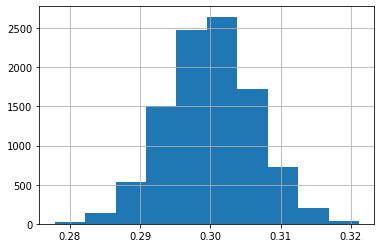

In [34]:
display(np.var(ctr1))
pd.Series(ctr1).hist()

## using a different definition, we have different variance

(10000,)

4.6694399337240525e-05

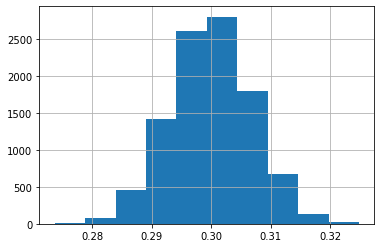

In [33]:
# CT2
# average each user's CTR
ctr2 = np.mean(clicks *1.0 / users_page, axis=1)
display(ctr2.shape)
display(np.var(ctr2))
pd.Series(ctr2).hist()

In [32]:
ctr2[:10]

array([0.29936699, 0.28297431, 0.30021615, 0.30894043, 0.29917096,
       0.30632883, 0.29582674, 0.30486972, 0.29996168, 0.30059107])

If I want to replicate the wrong calculation of variance in the book, I need to keep track of the number of clicks by each page. 

## Let's how the variance change according to the CTR

In [37]:
def generate_CTR(users=1000, CTR=0.3, avg_page = 4.5):
    users_page = np.random.poisson(avg_page, size=users) + 1
    clicks = np.random.binomial(users_page, CTR)
    
    ctr1 = np.sum(clicks, axis=1)*1.0 / np.sum(users_page, axis=1)
    ctr2 = np.mean(clicks *1.0 / users_page, axis=1)
    return np.var(ctr1), np.var(ctr2)
CTR_list = np.linspace(0.00,0.5, 20)[1:]
CTR_list[:5]

19


array([0.02631579, 0.05263158, 0.07894737, 0.10526316, 0.13157895])

In [38]:
res = []
for this_ctr in CTR_list:
    res.append(list(generate_CTR(users=(10000,1000),CTR=this_ctr)))

In [39]:
res_np = np.array(res)
res_np.shape

(19, 2)

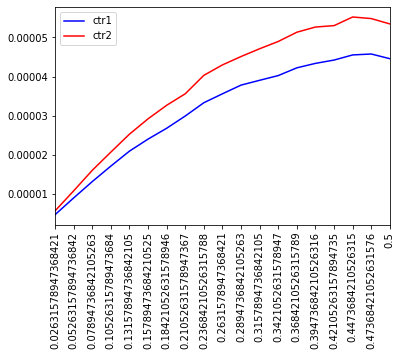

In [47]:
%precision %.2f
fig, ax = plt.subplots()
ax.plot(res_np[:, 0], label='ctr1',color='blue')
ax.plot(res_np[:, 1], label='ctr2',color='red')
ax.set_xlim((0, len(res_np)-1))
xticks=range(0, len(res_np))
_ = ax.set_xticks(xticks)
_ = ax.set_xticklabels(CTR_list, rotation=90)
ax.legend()

### The wrong way to calculate variance in CTR1
$$VAR(CTR_1) = \frac{\Sigma_{i=1}^n \Sigma_{j=1}^{K_j} (X_{ij} - CTR_1)^2}{}{N^2}$$

because I do not keep track of $X_{ij}$, I have to do it differently.

For each user $i$, we have $X_{ij}$ is either 0 or 1,so:
$$\Sigma_{j=1}^{K_j} (X_{ij} - CTR_1)^2$$
$$=NumClicks(1-CTR_1)^2 + (NumPage - NumClicks)CTR_1^2$$

applying this:

In [108]:
ctr1_broadcast = np.broadcast_to(ctr1, (1000, ctr1.shape[0])).T
display(ctr1)
display(ctr1_broadcast[:5, :5])

array([0.30660989, 0.29372937, 0.30558048, ..., 0.30500814, 0.29878721,
       0.29732175])

array([[0.30660989, 0.30660989, 0.30660989, 0.30660989, 0.30660989],
       [0.29372937, 0.29372937, 0.29372937, 0.29372937, 0.29372937],
       [0.30558048, 0.30558048, 0.30558048, 0.30558048, 0.30558048],
       [0.30457587, 0.30457587, 0.30457587, 0.30457587, 0.30457587],
       [0.29665763, 0.29665763, 0.29665763, 0.29665763, 0.29665763]])

In [109]:
display(clicks.shape, users_page.shape, ctr1_broadcast.shape)

(10000, 1000)

(10000, 1000)

(10000, 1000)

In [110]:
square_term = clicks * (1- ctr1_broadcast)**2 
square_term = square_term + (users_page - clicks)*ctr1_broadcast**2
square_term.shape

var_term = np.sum(square_term, axis=1) / square_term.shape[1]**2
display(var_term.shape)
var_term[:10]

(10000,)

array([0.00114825, 0.00113145, 0.0011826 , 0.00117109, 0.00115489,
       0.00115312, 0.00117234, 0.00116618, 0.00115127, 0.0011668 ])

0.0011549244788413313

3.7969715415811184e-10

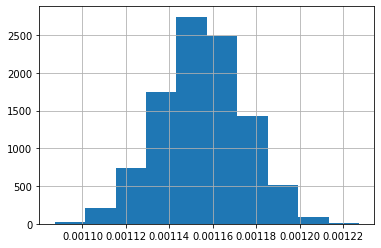

In [111]:
var_term = pd.Series(var_term)
display(var_term.hist())
display(var_term.mean(), var_term.var())

In [112]:
np.var(ctr1) / var_term.mean()

0.033041748347403456

so the wrong variance is much larger than the true variance. 

According to the book, this leads to $CTR_1$ was satistically significant far more often than the expected 5%. Is it true? I think my wrong variance is smaller than the true variance.

Let's look at the simulation

## Using the right variance, p-value is Uniformly distributed

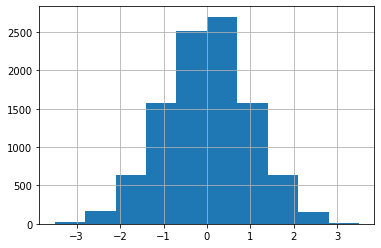

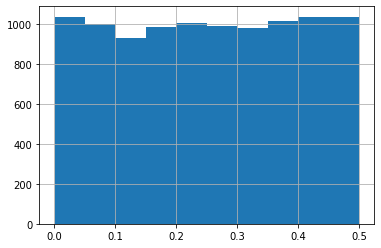

In [98]:
t_stat = (ctr1 - CTR)/np.std(ctr1)
pval = stats.t.sf(abs(t_stat), 1000-1)
display(pd.Series(t_stat).hist())
plt.show()
display(pd.Series(pval).hist())

### What if I use a smaller wrong variance
p value is significant much more than before

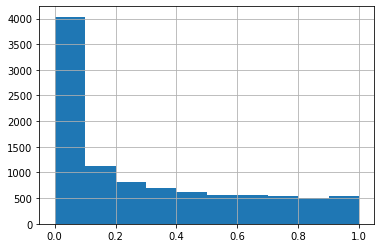

In [97]:
t_stat2 = (ctr1 - CTR)/np.std(ctr1) * 2
pval2 = stats.t.sf(abs(t_stat2), 1000-1) * 2
display(pd.Series(pval2).hist())

### What if I use a larger wrong variance

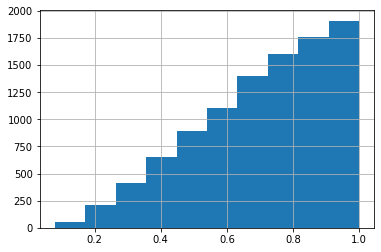

In [99]:
t_stat2 = (ctr1 - CTR)/np.std(ctr1) / 2
pval2 = stats.t.sf(abs(t_stat2), 1000-1) * 2
display(pd.Series(pval2).hist())

## so if we have t values without the variance, we can calculate the variance so that p-value's distribution is as close to uniform as possible

## Using the wrong variance, p-value is not normally distributed

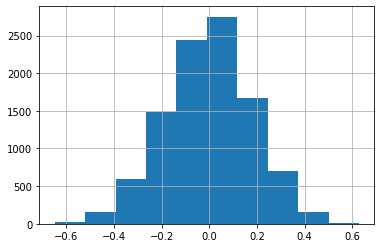

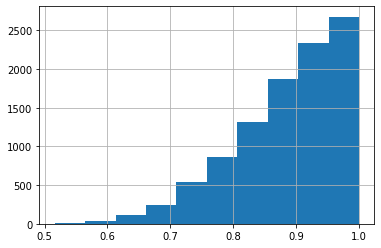

In [101]:
# https://stackoverflow.com/questions/17559897/python-p-value-from-t-statistic
t_stat = (ctr1 - CTR)/np.sqrt(var_term)
pval = stats.t.sf(abs(t_stat), 1000-1) * 2
display(pd.Series(t_stat).hist())
plt.show()
display(pd.Series(pval).hist())

### The variance is too large so the value is not significantly different from the assume CTR of 0.3

According to the book, this leads to $CTR_1$ was satistically significant far more often than the expected 5%. Is it true? I think my simulation leads to a different answer.

## Since we are on this topic, let's examine the variance of binomial
I know the theoretical variance. Let's just see the empirical variance

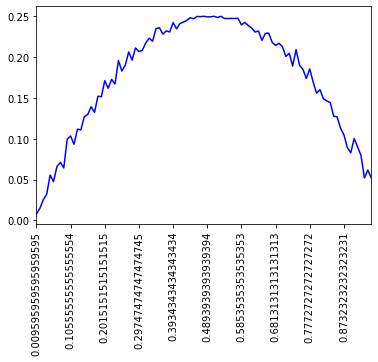

In [50]:
var_list = []

CTR_list2 = np.linspace(0.00,0.95, 100)[1:]

for this_CTR in CTR_list2:
    samples = np.random.binomial(n=1, p=this_CTR, size=1000)
    var_list.append(np.var(samples))

fig, ax = plt.subplots()
ax.plot(var_list, color='blue')

ax.set_xlim((0, len(var_list)-1))
xticks=list(range(0, len(var_list),10))
_ = ax.set_xticks(xticks)
_ = ax.set_xticklabels(CTR_list2[xticks], rotation=90)